# Viola-Jones Object Detection

In [1]:
from skimage.data import lfw_subset
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.feature import hessian_matrix
import matplotlib.patches as patches

from skimage import transform, io
from scipy.ndimage import maximum_filter,minimum_filter
from scipy.ndimage import gaussian_filter

plt.rcParams['text.color'] = 'w'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'
plt.rcParams['axes.labelcolor'] = 'w'
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)

IMPORT DATASET

In [2]:
# https://www.adamsmith.haus/python/docs/skimage.data.lfw_subset
# Returns
# -------
# images : (200, 25, 25) uint8 ndarray
# 100 first images are faces and subsequent 100 are non-faces.
#
# Notes
# -----
# The faces were randomly selected from the LFW dataset and the non-faces
# were extracted from the background of the same dataset. The cropped ROIs
# have been resized to a 25 x x25 pixels.

# http://vis-www.cs.umass.edu/lfw/ -> discrimination -> coded bias -> https://www.imdb.com/title/tt11394170/
data = lfw_subset()
data.shape

(200, 25, 25)

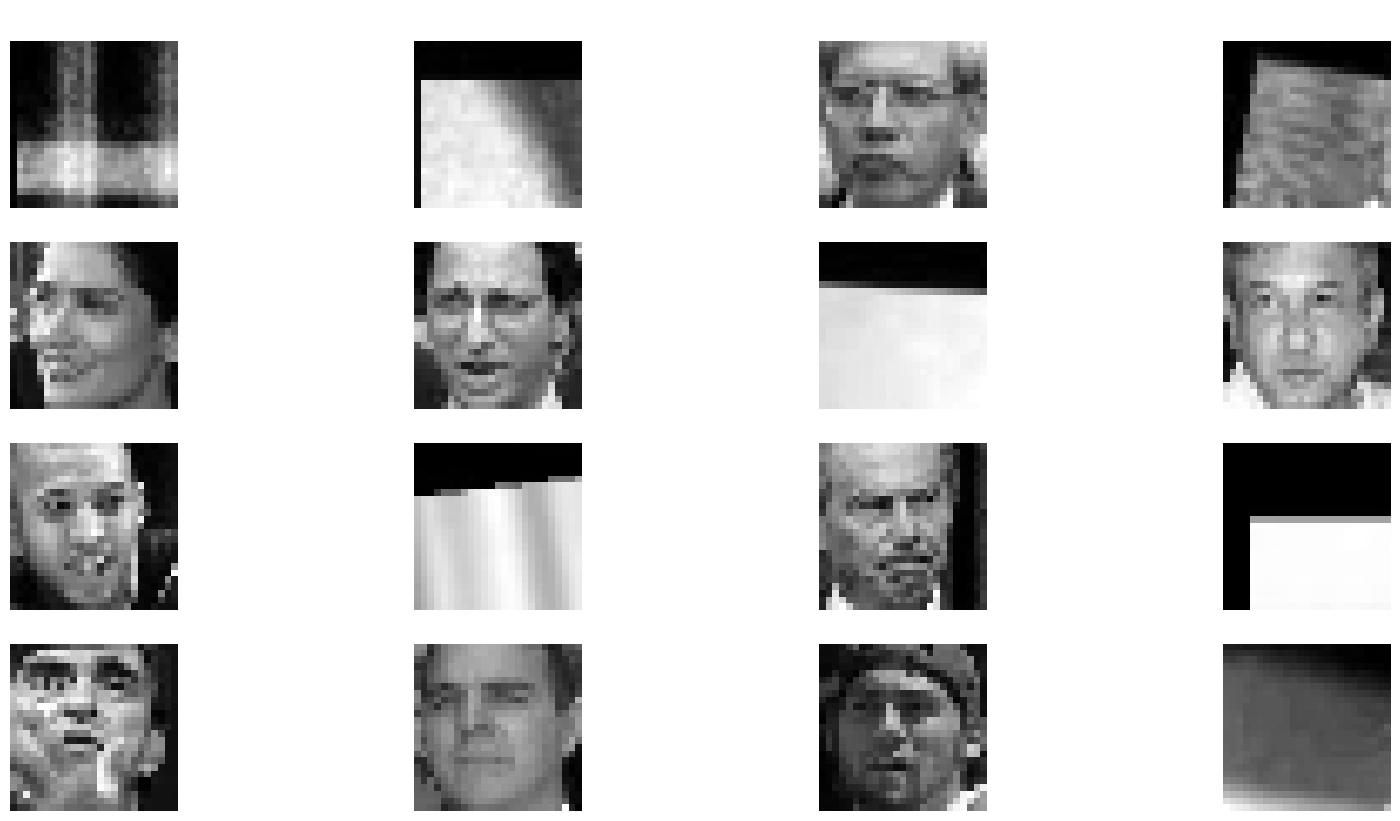

In [3]:
# SAMPLE PRINT
fig, axs = plt.subplots(4, 4,figsize=(20,10))
sample = np.random.randint(0,data.shape[0],16)

for i in range(16):
        idx = sample[i]
        im  = data[idx,:,:]
        rr = i//4
        cc = i%4
        axs[rr,cc].imshow(im,cmap='gray')
        axs[rr,cc].axis('off')
        axs[rr,cc].set_title("Img {}".format(idx))

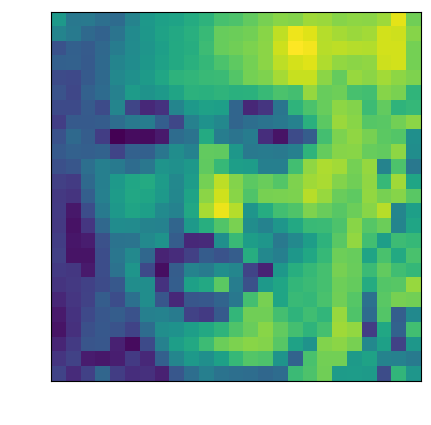

In [4]:
# Dataset include 200 images -  0-99 represent faces, 100-199 is not face
plt.imshow(data[50])
# plt.imshow(data[150])

## Integral image

In [5]:
# ones_img = np.ones((5, 5))
ones_img = np.random.randint(10,size=(5,5))
print(ones_img)
integrated_img = np.cumsum(np.cumsum(ones_img,axis=0),axis=1)
print(integrated_img)

[[3 8 8 4 9]
 [8 7 1 0 0]
 [5 8 9 0 8]
 [7 6 6 4 7]
 [8 2 9 5 9]]
[[  3  11  19  23  32]
 [ 11  26  35  39  48]
 [ 16  39  57  61  78]
 [ 23  52  76  84 108]
 [ 31  62  95 108 141]]


In [6]:
# 41
print(45-14-10+2)

m_1 = integrated_img[1,1]
print(m_1)
m_2 = integrated_img[1,2]
print(m_2)
m_3 = integrated_img[4,1]
print(m_3)
m_4 = integrated_img[4,3]
print(m_4)
print("sum under interested area: " + str(m_4 - m_2 - m_3 + m_1))

23
26
35
62
108
sum under interested area: 37


## Haar like features

In [7]:
test_image = data[50]
integral_img = np.cumsum(np.cumsum(test_image,axis=0),axis=1)

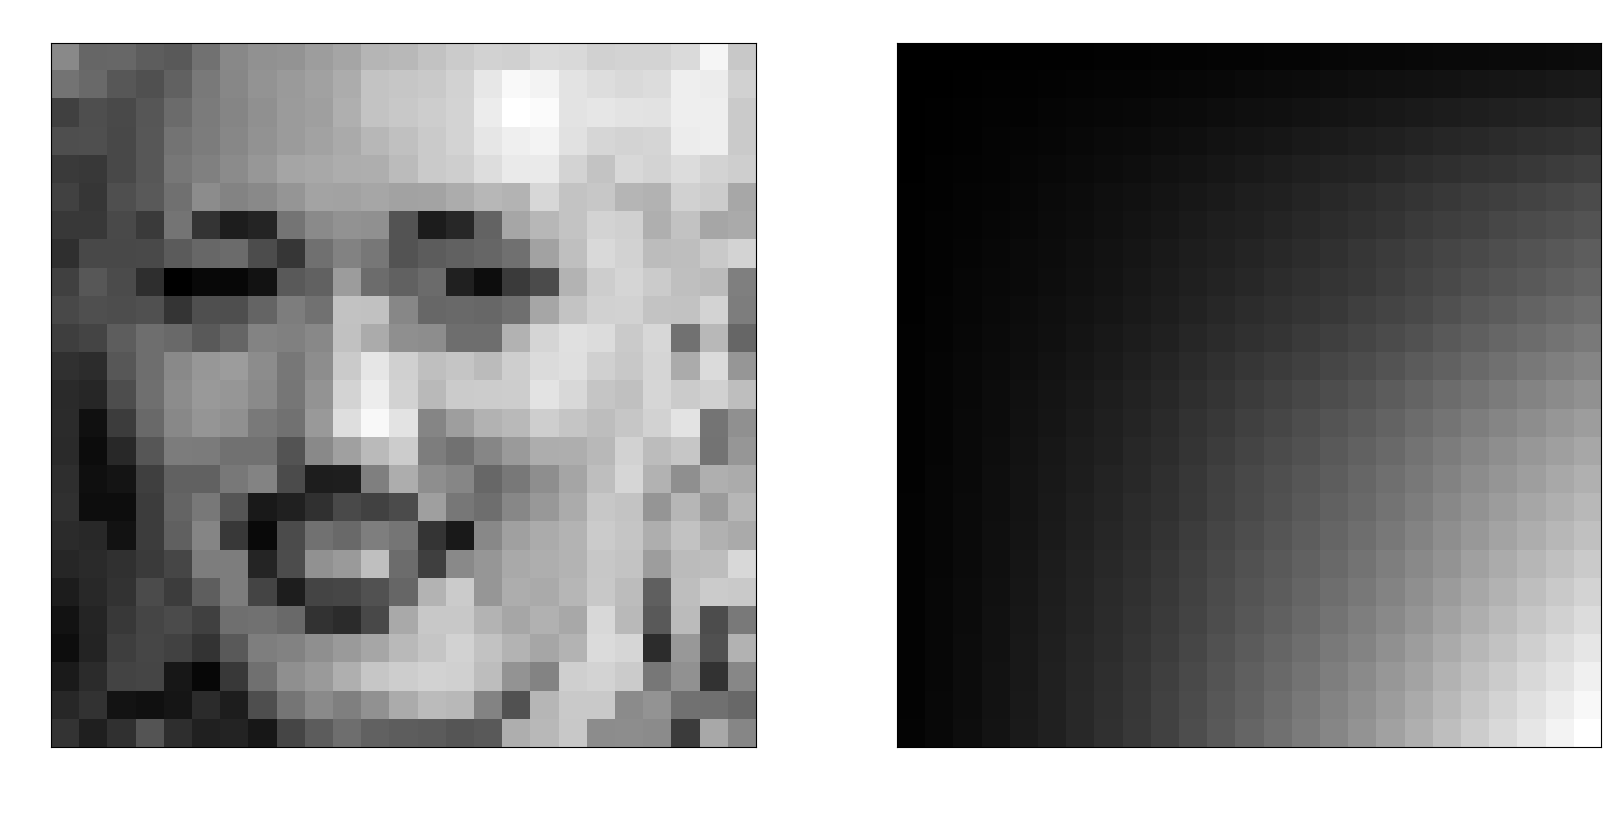

In [8]:
plt.figure(figsize=(20, 15))
ax1=plt.subplot(121)
ax1.imshow(test_image,cmap='gray')
ax1.set_title("Mesiac")
ax2 = plt.subplot(1,2,2)
ax2.imshow(integral_img ,cmap='gray')
ax2.set_title("Jasový histogram")
ax2.set_xlabel("Jasové úrovne")
ax2.set_ylabel("Počet pixelov");

In [9]:
rr = 10
cc = 10
rect_sum_black = integral_img[rr+3,cc+2] + integral_img[rr,cc] - integral_img[rr,cc+2] - integral_img[rr+3,cc]
rect_sum_white = integral_img[rr+6,cc+2] + integral_img[rr+3,cc] - integral_img[rr+6,cc]  - integral_img[rr+3,cc+2]

In [10]:
print(rect_sum_black)
print(rect_sum_white)

5.239215672016144
3.2928104996681213


In [11]:
haar = -rect_sum_black + rect_sum_white
haar

-1.9464051723480225

## AdaBoost
### Prepair data

In [12]:
train_set = np.concatenate((data[0:50,...],data[100:150,...]))
test_set = np.concatenate((data[50:100,...],data[150:200,...]))

# is same for train and test (same class distribution)
Y = np.concatenate((np.ones((50,)),np.zeros((50,))))

features = np.zeros(shape=(train_set.shape[0],(train_set.shape[1]-6)*(train_set.shape[2]-3)))
features_test = np.zeros(shape=(test_set.shape[0],(test_set.shape[1]-6)*(test_set.shape[2]-3)))

features.shape

(100, 418)

In [13]:
## TRAIN
for i in range(train_set.shape[0]):
        img = train_set[i,...]
        # get integral image
        integral_img = np.cumsum(np.cumsum(img,axis=0),axis=1)
        it = 0
        # iterate over image
        for rr in range(img.shape[0]-6):
                for cc in range(img.shape[1]-3):
                        # Haar futures -> on integral image -? m_4 - m_2 - m_3 + m_1
                        rect_sum_black = integral_img[rr+3,cc+2] + integral_img[rr,cc] - integral_img[rr,cc+2] - integral_img[rr+3,cc]

                        rect_sum_white = integral_img[rr+6,cc+2] + integral_img[rr+3,cc] - integral_img[rr+6,cc]  - integral_img[rr+3,cc+2]

                        haar = -rect_sum_black + rect_sum_white

                        features[i,it] = haar
                        it = it +1

In [14]:
## TEST
features_test = np.zeros(shape=(test_set.shape[0],(test_set.shape[1]-6)*(test_set.shape[2]-3)))
# iterate over train dataset
for i in range(test_set.shape[0]):
        img = test_set[i,...]
        # get integral image
        integral_img = np.cumsum(np.cumsum(img,axis=0),axis=1)
        it = 0
        # iterate over image
        for rr in range(img.shape[0]-6):
                for cc in range(img.shape[1]-3):

                        # Haar futures -> on integral image -? m_4 - m_2 - m_3 + m_1
                        rect_sum_black = integral_img[rr+3,cc+2] + integral_img[rr,cc] - integral_img[rr,cc+2] - integral_img[rr+3,cc]
                        rect_sum_white = integral_img[rr+6,cc+2] + integral_img[rr+3,cc] - integral_img[rr+6,cc]  - integral_img[rr+3,cc+2]

                        haar = -rect_sum_black + rect_sum_white

                        features_test[i,it] = haar
                        it = it +1

In [15]:
features.shape

(100, 418)

### Train

In [16]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
# Y = np.concatenate((np.ones((50,)),np.zeros((50,))))
clf = AdaBoostClassifier(n_estimators=400, random_state=0)
clf.fit(features, Y)


print(clf.score(features, Y))

1.0


### Eval

0.91


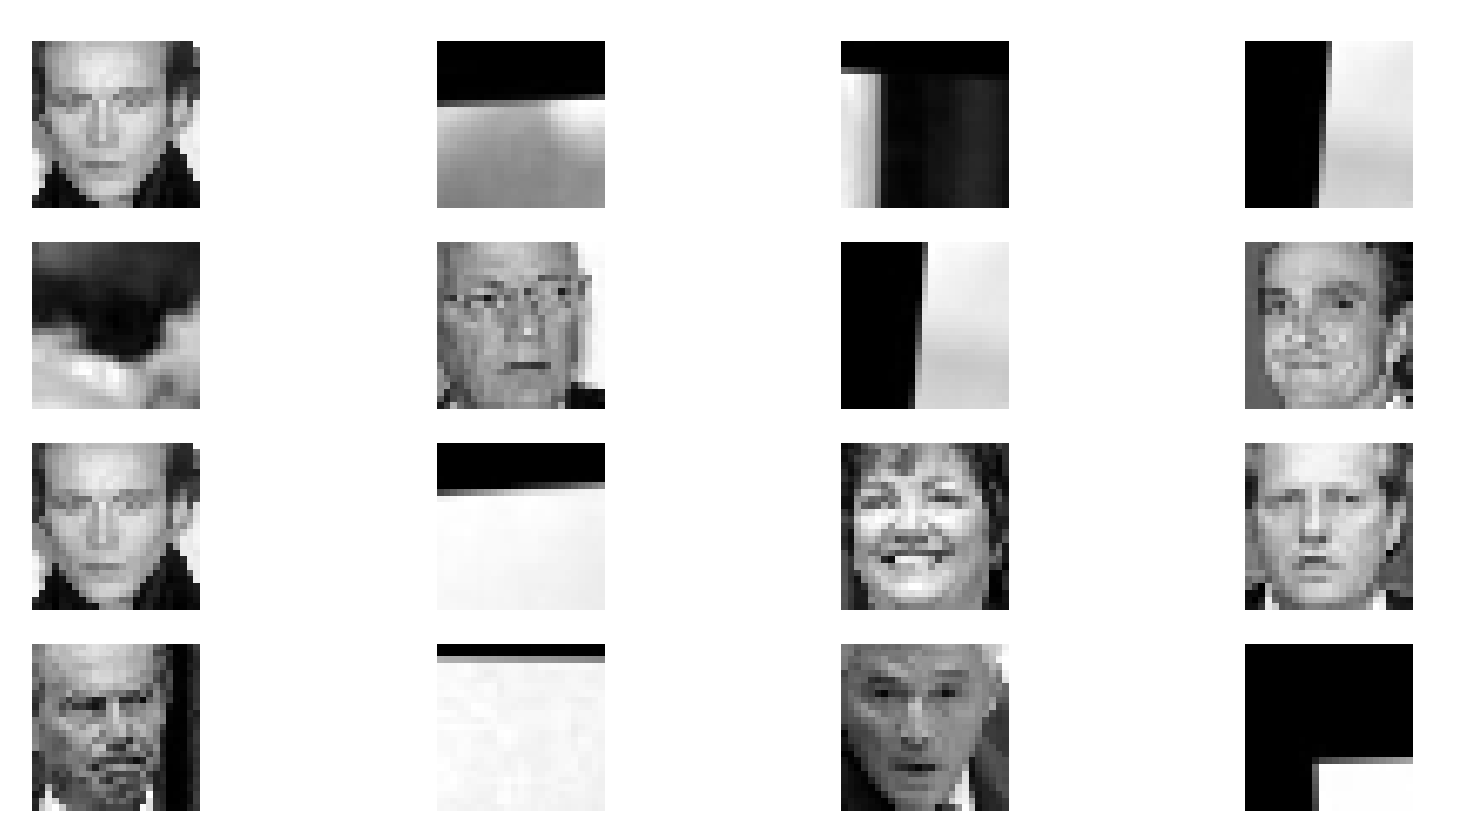

In [17]:
# Y - > can keep - same label split 50/50
Y_pred = clf.predict(features_test)
print(clf.score(features_test, Y))

fig, axs = plt.subplots(4, 4,figsize=(20,10))
sample = np.random.randint(0,test_set.shape[0],16)

for i in range(16):
        idx = sample[i]
        im  = test_set[idx,:,:]
        rr = i//4
        cc = i%4
        axs[rr,cc].imshow(im,cmap='gray')
        axs[rr,cc].axis('off')
        if (Y_pred[idx] == 1):
                axs[rr,cc].set_title("Img {} is face".format(idx))
        else:
                axs[rr,cc].set_title("Img {} NOT a face".format(idx))

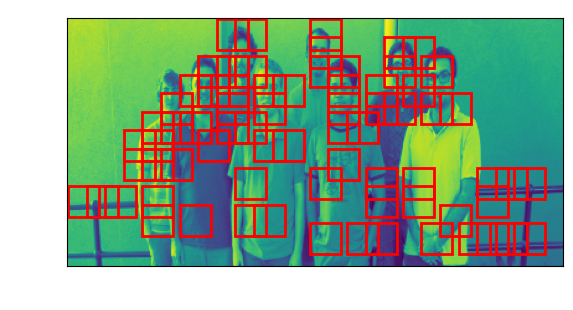

In [18]:
img_orig = transform.resize(rgb2gray(io.imread("../_data/faces.jpeg")),(200,400))
img_faces = np.cumsum(np.cumsum(img_orig,axis=0),axis=1)
# Create figure and axes
fig, ax = plt.subplots()
ax.imshow(img_orig)
step = 15
for i in np.arange(0,img_faces.shape[0]-25,step):
        for j in np.arange(0,img_faces.shape[1]-25,step):

                integral_img = img_faces[i:i+25,j:j+25]
                haar_features = np.zeros(shape=(1,(img.shape[0]-6)*(img.shape[1]-3)))
                it = 0

                for rr in range(img.shape[0]-6):
                        for cc in range(img.shape[1]-3):
                                rect_sum_black = integral_img[rr+3,cc+2] + integral_img[rr,cc] - integral_img[rr,cc+2] - integral_img[rr+3,cc]
                                rect_sum_white = integral_img[rr+6,cc+2] + integral_img[rr+3,cc] - integral_img[rr+6,cc]  - integral_img[rr+3,cc+2]

                                haar = - rect_sum_black + rect_sum_white
                                haar_features[0,it] = haar
                                it = it +1

                Y_pred = clf.predict(haar_features)

                if Y_pred ==1:
                        rect = patches.Rectangle((j, i), 25, 25, linewidth=2, edgecolor='r', facecolor='none')
                        ax.add_patch(rect)

# Viola-Jones (Full implementation)

## Enhance dataset

In [19]:
# support functions
def return_sum_of_area(integral_img, rr, cc, hh, ww):
        area_sum = integral_img[rr+hh,cc+ww] + integral_img[rr,cc] - integral_img[rr,cc+ww] - integral_img[rr+hh,cc]
        return area_sum

def resize_stack(stack,out_shape):
        out_stack = np.empty((stack.shape[0],out_shape[0],out_shape[1]))
        for i, image in zip(range(stack.shape[0]),stack):
                out_stack[i,...] = transform.resize(image,out_shape)
        return out_stack

In [20]:
from sklearn.datasets import fetch_lfw_people
lfw_subset_data = lfw_subset()
lfw_subset_norm = lfw_subset_data/255

img_stack = np.array([])
lfw_people = fetch_lfw_people(min_faces_per_person=1)
imgs_resized = resize_stack(lfw_people.images/255,(25,25))

In [21]:
# download another dataset
import torch
import torchvision
torch.manual_seed(17)

data_transform = torchvision.transforms.Compose([torchvision.transforms.Grayscale(),
                                                 torchvision.transforms.Resize(size=(25,25)),
                                                 torchvision.transforms.ToTensor()])

dataset = torchvision.datasets.CIFAR10("../data/faces/",transform=data_transform,download=True)

imgs_cifar = np.zeros((10000,25,25))

idx = np.random.randint(0,len(dataset),10000)
for i in range(10000):
        im,_ = dataset.__getitem__(idx[i])
        imgs_cifar[i,:,:] = np.squeeze(im.cpu().detach().numpy())

Files already downloaded and verified


In [22]:
# merge old and new data
data_faces = np.concatenate((lfw_subset_norm[0:100,...],imgs_resized[0:10000,...]))
data_non_faces = np.concatenate((lfw_subset_norm[100:200,...],imgs_cifar[0:10000,...]))

In [23]:
# CREATE DATASET -> merge face/noface + add label
dataset = np.concatenate((data_faces,data_non_faces))
Y_dataset = np.concatenate((np.ones((10100,)),np.zeros((10100,))))

# SPLIT DATAST
# split train/test % face/noface
dataset_train_set = np.concatenate((dataset[0:1000,...],dataset[10100:11100,...]))
Y_dataset_train = np.concatenate((Y_dataset[0:1000,...],Y_dataset[10100:11100,...]))

dataset_test_set = np.concatenate((dataset[1000:2000,...],dataset[11100:12100,...]))
Y_dataset_test  = np.concatenate((Y_dataset[1000:2000,...],Y_dataset[11100:12100,...]))

## Haar features

In [24]:
def edge_feature(integral_img, rr, cc, hh, ww, isVertical=True):
        N=hh//2*ww//2
        if isVertical:
                sum_white =  return_sum_of_area(integral_img,rr,cc,hh,ww//2)
                sum_black =  return_sum_of_area(integral_img,rr,cc+ww//2,hh,ww//2)
                return sum_white/N-sum_black/N
        else:
                sum_white =  return_sum_of_area(integral_img,rr,cc,hh//2,ww)
                sum_black =  return_sum_of_area(integral_img,rr+hh//2,cc,hh//2,ww)
                return sum_white/N-sum_black/N


def line_feature(integral_img, rr, cc, hh, ww, isVertical=True):
        N_w=hh//2*ww//2
        N_b=hh//4*ww//4

        if isVertical:
                sum_white1 =  return_sum_of_area(integral_img,rr,cc,hh,ww//4)
                sum_black1 =  return_sum_of_area(integral_img,rr,cc+ww//4,hh,ww//2)
                sum_white2 =  return_sum_of_area(integral_img,rr,cc+(3*(ww//4)),hh,ww//4)

                return sum_white1/N_w-sum_black1/N_b +sum_white2/N_w
        else:
                sum_white1 =  return_sum_of_area(integral_img,rr,cc,hh//4,ww)
                sum_black1 =  return_sum_of_area(integral_img,rr+hh//4,cc,hh//2,ww)
                sum_white2 =  return_sum_of_area(integral_img,rr+(3*(hh//4)),cc,hh//4,ww)

                return sum_white1/N_w-sum_black1/N_b +sum_white2/N_w

### Feature extraction

In [25]:
# from tqdm.notebook import tqdm
features_edge_horizontal = list()
features_edge_vertical = list()
features_line_horizontal = list()
features_line_vertical = list()
features = list()

hhs = [5, 7, 9]
wws = [5]

for i in range(dataset_train_set.shape[0]):
        img = dataset_train_set[i,...]
        integral_img = np.cumsum(np.cumsum(img,axis=0),axis=1)

        image_features_edge_horizontal= list()
        image_features_edge_vertical = list()
        image_features_line_horizontal = list()
        image_features_line_vertical = list()

        for hh in hhs:
                for ww in wws:
                        for rr in range(img.shape[0]-hh):
                                for cc in range(img.shape[1]-ww):

                                        # extract
                                        edge_vertical = edge_feature(integral_img,rr,cc,hh,ww)
                                        edge_horizontal = edge_feature(integral_img,rr,cc,hh,ww,isVertical=False)
                                        line_vertical  = line_feature(integral_img,rr,cc,hh,ww)
                                        line_horizontal  = line_feature(integral_img,rr,cc,hh,ww,isVertical=False)

                                        # append per image
                                        image_features_edge_horizontal+= [edge_horizontal]
                                        image_features_edge_vertical+= [edge_vertical]
                                        image_features_line_horizontal+= [line_horizontal]
                                        image_features_line_vertical+= [line_vertical]



        # append per dataset
        features_edge_horizontal +=[image_features_edge_horizontal]
        features_edge_vertical+=[image_features_edge_vertical]
        features_line_horizontal+=[image_features_line_horizontal]
        features_line_vertical+=[image_features_line_vertical]

        features+= [image_features_edge_horizontal+image_features_edge_vertical + image_features_line_horizontal+image_features_line_vertical]

        features.append(features)


## Train classificators

In [ ]:
lr=1
# The classifier uses only one estimator, one Haar feature. The most general estimator that lets out a minimum of false negatives. Release false positives that will be filtered out later. At this point, most of the incoming tiles end and do not look further.
clf = AdaBoostClassifier(n_estimators=1,learning_rate=lr)
clf.fit(features, Y_dataset_train)
# print(clf.score(features, Y_dataset_train))

/Users/hlibokymaros/opt/anaconda3/envs/KKUI-PPV_LABs/lib/python3.9/site-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


In [ ]:

clf1 = AdaBoostClassifier(n_estimators=5,learning_rate=lr)
clf1.fit(features, Y_dataset_train)
print(clf1.score(features, Y_dataset_train))

clf2 = AdaBoostClassifier(n_estimators=25,learning_rate=lr)
clf2.fit(features, Y_dataset_train)
print(clf2.score(features, Y_dataset_train))

clf3 = AdaBoostClassifier(n_estimators=50,learning_rate=lr)
clf3.fit(features, Y_dataset_train)
print(clf3.score(features, Y_dataset_train))

/Users/hlibokymaros/opt/anaconda3/envs/KKUI-PPV_LABs/lib/python3.9/site-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


## Cascade classifier

In [ ]:
img_orig = transform.resize(rgb2gray(io.imread("img/faces.jpeg")),(200,400))
img_faces = np.cumsum(np.cumsum(img_orig,axis=0),axis=1)
fig, ax = plt.subplots()
ax.imshow(img_orig)
step = 10

for i in tqdm(np.arange(0,img_faces.shape[0]-25,step)):
        for j in np.arange(0,img_faces.shape[1]-25,step):
                integral_img = img_faces[i:i+25,j:j+25]
                feats = list()
                image_features_edge_horizontal= list()
                image_features_edge_vertical = list()
                image_features_line_horizontal = list()
                image_features_line_vertical = list()

                for hh in hhs:
                        for ww in wws:
                                for rr in range(img.shape[0]-hh):
                                        for cc in range(img.shape[1]-ww):
                                                edge_vertical = edge_feature(integral_img,rr,cc,hh,ww)
                                                edge_horizontal = edge_feature(integral_img,rr,cc,hh,ww,isVertical=False)
                                                line_vertical  = line_feature(integral_img,rr,cc,hh,ww)
                                                line_horizontal  = line_feature(integral_img,rr,cc,hh,ww,isVertical=False)

                                                image_features_edge_horizontal+= [edge_horizontal]
                                                image_features_edge_vertical+= [edge_vertical]
                                                image_features_line_horizontal+= [line_horizontal]
                                                image_features_line_vertical+= [line_vertical]
                feature = image_features_edge_horizontal + image_features_edge_vertical + image_features_line_horizontal+image_features_line_vertical

                # Cascade classifier
                if clf.predict([feature]):
                        if clf1.predict([feature]):
                                if clf2.predict([feature]):
                                        if clf3.predict([feature]):

                                                rect = patches.Rectangle((j, i), 25, 25, linewidth=2, edgecolor='r', facecolor='none')
                                                ax.add_patch(rect)